## Машинное обучение 

## Семинар 2

## `sklearn` и линейная регрессия

На этом семинаре мы:
* Обучим линейную регрессию для предсказания цены дома;
* Посмотрим на отличие между разными регуляризаторами;
* Научимся пользоваться основными инструментами в `sklearn`: моделями, трансформерами и pipeline;
* Обсудим преобразования признаков и целевой переменной, которые могут помочь в обучении линейных моделей.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

# Часть 0. Введение в линейные модели

Напомним, что линейная регрессия &mdash; это модель следующего вида:
$$a(x) = \langle w, x \rangle + w_0$$
где $w \in \mathbb{R}^d$, $w_0 \in \mathbb{R}$. Обучить линейную регрессию &mdash; значит найти $w$ и $w_0$.

В машинном обучении часто говорят об *обобщающей способности модели*, то есть о способности модели работать на новых, тестовых данных хорошо. Если модель будет идеально предсказывать выборку, на которой она обучалась, но при этом просто ее запомнит, не "вытащив" из данных никакой закономерности, от нее будет мало толку. Такую модель называют *переобученной*: она слишком подстроилась под обучающие примеры, не выявив никакой полезной закономерности, которая позволила бы ей совершать хорошие предсказания на данных, которые она ранее не видела.

Рассмотрим следующий пример, на котором будет хорошо видно, что значит переобучение модели. Для этого нам понадобится сгенерировать синтетические данные. Рассмотрим зависимость $y(x) = \cos(1.5\pi x)$, $y$ &mdash; целевая переменная, а $x$ - объект (просто число от 0 до 1). В жизни мы наблюдаем какое-то конечное количество пар объект-таргет, поэтому смоделируем это, взяв 30 случайных точек $x_i$ в отрезке $[0;1]$. Более того, в реальной жизни целевая переменная может быть зашумленной (измерения в жизни не всегда точны), смоделируем это, зашумив значение функции нормальным шумом: $\tilde{y}_i = y(x_i) + \mathcal{N}(0, 0.01)$.

Попытаемся обучить три разных линейных модели: признаки для первой &mdash;  $\{x\}$, для второй &mdash; $\{x, x^2, x^3, x^4\}$, для третьей &mdash; $\{x, \dots, x^{20}\}$.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [3]:
np.random.seed(36)
X = np.linspace(0, 1, 100).reshape((-1,1))
Y = np.cos(1.5 * np.pi * X)

X_l = np.random.uniform(0, 1, size=30).reshape((-1,1))
Y_l = np.cos(1.5 * np.pi * X_l) + np.random.normal(scale=0.1, size=X_l.shape)

In [4]:
def plot(i, X, Y, X_l, Y_l, Y_pred): 
    axs[i].plot(X, Y, label="Real function")
    axs[i].scatter(X_l, Y_l, label="Data")
    axs[i].plot(X, Y_pred, label="Prediction")
    if i == 0:
        axs[i].legend()
    axs[i].set_title("Degree = %d" % degree)
    axs[i].set_xlabel("$x$")
    axs[i].set_ylabel("$f(x)$")
    axs[i].set_ylim(-2, 2)

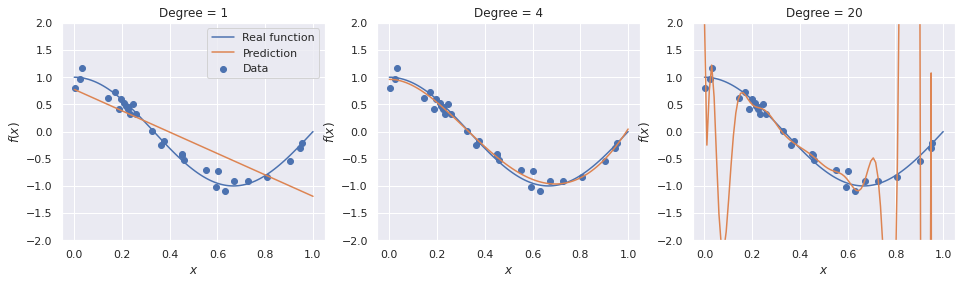

In [5]:
fig, axs = plt.subplots(figsize=(16, 4), ncols=3)

for i, degree in enumerate([1, 4, 20]):
    pf = PolynomialFeatures(degree)
    pf.fit(X_l)
    
    model = LinearRegression() 
    
    model.fit(pf.transform(X_l), Y_l)
    
    Y_pred = model.predict(pf.transform(X))
    
    plot(i, X, Y, X_l, Y_l, Y_pred)

**Вопрос 1**: Почему первая модель получилась плохой, а третья переобучилась?

Чтобы избежать переобучения, модель регуляризуют. Обычно переобучения в линейных моделях связаны с большими весами, а поэтому модель часто штрафуют за большие значения весов, добавляя к функционалу качества, например, квадрат $\ell^2$-нормы вектора $w$:

$$Q_{reg}(X, y, a) = Q(X, y, a) + \lambda \|w\|_2^2$$

Это слагаемое называют $\ell_2$-регуляризатором, а коэффициент $\lambda$ &mdash; коэффициентом регуляризации. Более подробно о регуляризации и переобучении вы узнаете из лекций.

**Вопрос 2**: Почему большие веса в линейной модели &mdash; плохо?

**Вопрос 3**: На что влияет коэффициент $\lambda$? Что будет происходить с моделью, если $\lambda$ начать уменьшать? Что будет, если $\lambda$ сделать слишком большим?

# Часть 1. Загружаем данные

Мы будем работать с данными из соревнования [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview), в котором требовалось предсказать стоимость жилья. Давайте сначала загрузим и немного изучим данные.

In [6]:
data = pd.read_csv("./train.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# ! pip install pandas-profiling[notebook]

# from pandas_profiling import ProfileReport

# profile = ProfileReport(data, title="Pandas Profiling Report")

In [7]:
data.shape

(1460, 81)

In [8]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Первое, что стоит заметить &mdash; у нас в данных есть уникальное для каждого объекта поле id. Обычно такие поля только мешают и способствуют переобучению. Удалим это поле из данных.

Разделим данные на обучающую и тестовую выборки. Для простоты не будем выделять дополнительно валидационную выборку (хотя это иногда это стоит делать, она нужна для подбора гиперпараметров модели, то есть параметров, которые нельзя подбирать по обучающей выборке). Дополнительно нам придется отделить значения целевой переменной от данных.

**Вопрос 1**: Почему поля типа id могут вызвать переобучение модели (не обязательно линейной)?

**Вопрос 2**: Почему стоит дополнительно отделять валидационную выборку?

**Вопрос 3**: Обратите внимание на фиксацию `random_state` при сплите данных. Почему это важно?

In [9]:
from sklearn.model_selection import train_test_split

# data = data.drop(columns=["Id"])
del data['Id']

y = data["SalePrice"]
X = data.drop(columns=["SalePrice"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Посмотрим сначала на значения целевой переменной.

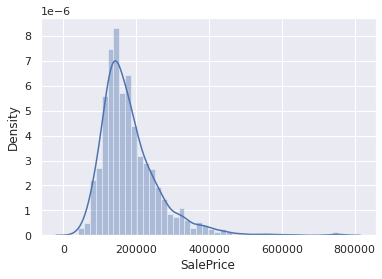

In [10]:
sns.distplot(y_train)

Судя по гистограмме, у нас есть примеры с нетипично большой стоимостью, что может помешать нам, если наша функция потерь слишком чувствительна к выбросам. В дальнейшем мы рассмотрим способы, как минимизировать ущерб от этого.

Так как для решения нашей задачи мы бы хотели обучить линейную регрессию, было бы хорошо найти признаки, "наиболее линейно" связанные с целевой переменной, иначе говоря, посмотреть на коэффициент корреляции Пирсона между признаками и целевой переменной. Заметим, что не все признаки являются числовыми, пока что мы не будем рассматривать такие признаки.

**Вопрос**: Что означает, что коэффициент корреляции Пирсона между двумя случайными величинами равен 1? -1? 0?

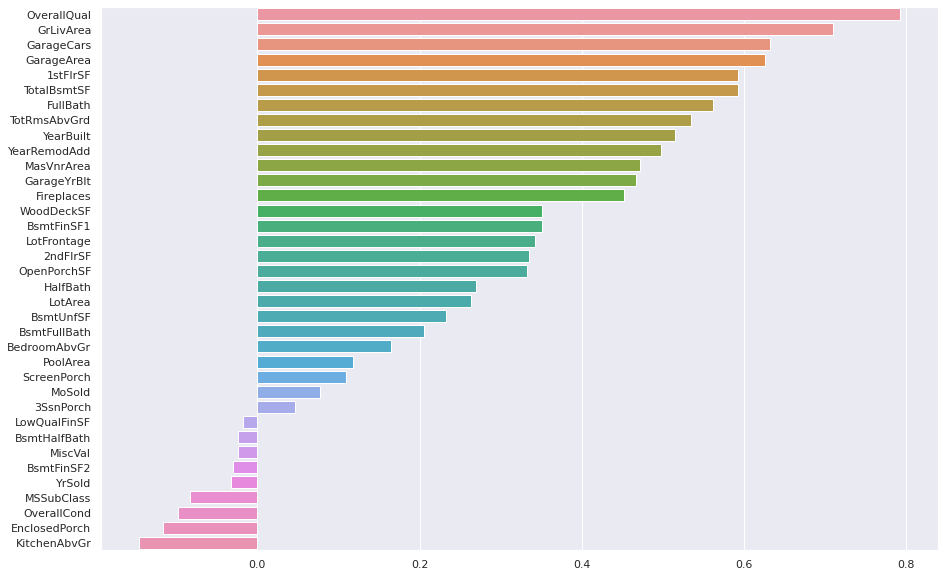

In [11]:
numeric_data = X_train.select_dtypes([np.number])

numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)


plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

Посмотрим на признаки из начала списка. Для этого нарисуем график зависимости целевой переменной от каждого из признаков. На этом графике каждая точка соответствует паре признак-таргет (такие графики называются scatter-plot).

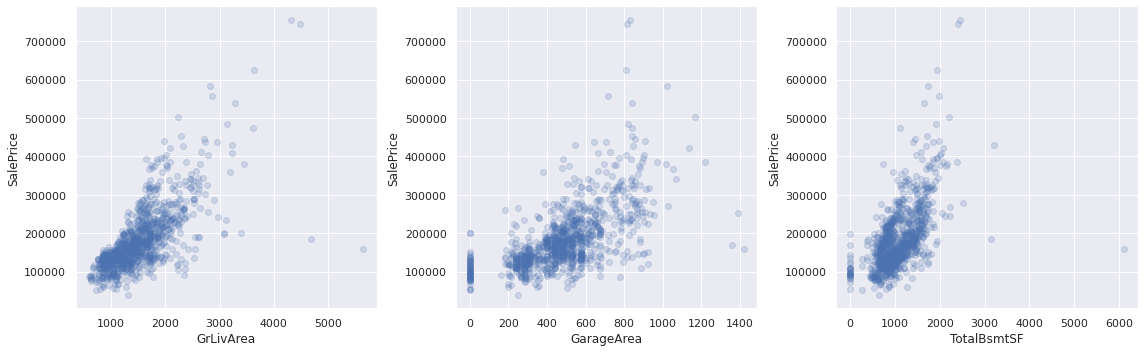

In [12]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(["GrLivArea", "GarageArea", "TotalBsmtSF"]):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("SalePrice")
plt.tight_layout()

Видим, что между этими признаками и целевой переменной действительно наблюдается линейная зависимость.

# Часть 2. Первая модель

*Немного об обучении моделей*. В арсенале дата-саентиста кроме `pandas` и `matplotlib` должны быть библиотеки, позволяющие обучать модели. Для простых моделей (линейные модели, решающее дерево, ...) отлично подходит `sklearn`: в нем очень понятный и простой интерфейс. Несмотря на то, что в `sklearn` есть реализация бустинга и простых нейронных сетей, ими все же не пользуются и предпочитают специализированные библиотеки: `XGBoost`, `LightGBM` и пр. для градиентного бустинга над деревьями, `PyTorch`, `Tensorflow` и пр. для нейронных сетей. Так как мы будем обучать линейную регрессию, нам подойдет реализация из `sklearn`.

Попробуем обучить линейную регрессию на числовых признаках из нашего датасета. В `sklearn` есть несколько классов, реализующих линейную регрессию:
* [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) &mdash; "классическая" линейная регрессия с оптимизацией MSE. 
* [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) &mdash; линейная регрессия с оптимизацией MSE и $\ell_2$-регуляризацией
* [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) &mdash; линейная регрессия с оптимизацией MSE и $\ell_1$-регуляризацией

У моделей из `sklearn` есть методы `fit` и `predict`. Первый принимает на вход обучающую выборку и вектор целевых переменных и обучает модель, второй, будучи вызванным после обучения модели, возвращает предсказание на выборке. Попробуем обучить нашу первую модель на числовых признаках, которые у нас сейчас есть:

In [13]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

model = Ridge()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred))

Test MAE = 23115.5140
Train MAE = 21403.8477


Мы обучили первую модель и даже посчитали ее качество на отложенной выборке! Давайте теперь посмотрим на то, как можно оценить качество модели с помощью кросс-валидации. Принцип кросс-валидации изображен на рисунке

<img src="https://docs.splunk.com/images/thumb/e/ee/Kfold_cv_diagram.png/1200px-Kfold_cv_diagram.png" width=50%>

При кросс-валидации мы делим обучающую выборку на $n$ частей (fold). Затем мы обучаем $n$ моделей: каждая модель обучается при отсутствии соответствующего фолда, то есть $i$-ая модель обучается на всей обучающей выборке, кроме объектов, которые попали в $i$-ый фолд (out-of-fold). Затем мы измеряем качество $i$-ой модели на $i$-ом фолде. Так как он не участвовал в обучении этой модели, мы получим "честный результат". После этого, для получения финального значения метрики качества, мы можем усреднить полученные нами $n$ значений.

In [14]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring="neg_mean_absolute_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV MAE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -23300.6071
	-25210.1339
	-23025.1377
	-25031.0888
	-24134.6262
	-17875.8892
	-21254.5331
	-26403.8845
	-22160.8782
	-21016.7669
Mean CV MAE = 22941.3545


Обратите внимание на то, что результаты `cv_scores` получились отрицательными. Это соглашение в `sklearn` (скоринговую функцию нужно максимизировать). Поэтому все стандартные скореры называются `neg_*`, например, `neg_root_mean_squared_error`.

Обратите внимание, что по отложенной выборке и при кросс-валидации мы считаем MAE (Mean Absolute Error), хотя в функционале ошибки при обучении модели используется MSE.

$$\text{MSE}(X, y, a) = \frac{1}{\ell}\sum_{i=1}^{\ell} (y_i - a(x_i))^2$$

Если бы RMSE не входил в стандартные метрики `sklearn`, можно было бы его определить через функцию `sklearn.metrics.make_scorer`.

In [15]:
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

In [16]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring=rmse_scorer)
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -38825.3172
	-45278.9230
	-31405.3380
	-33890.1048
	-73848.3061
	-24142.7915
	-45523.7066
	-52861.2908
	-26094.3376
	-29693.5005
Mean CV RMSE = 40156.3616


Для того, чтобы иметь некоторую точку отсчета, удобно посчитать оптимальное значение функции потерь при константном предсказании.

In [17]:
best_constant = y_train.mean()
print("Test MAE with constant = %.4f" % mean_absolute_error(y_test, best_constant * np.ones(y_test.shape)))
print("Train MAE with constant = %.4f" % mean_absolute_error(y_train, best_constant * np.ones(y_train.shape)))

Test MAE with constant = 57311.3914
Train MAE with constant = 57888.8833


In [18]:
best_constant = y_train.median()
print("Test MAE with constant = %.4f" % mean_absolute_error(y_test, best_constant * np.ones(y_test.shape)))
print("Train MAE with constant = %.4f" % mean_absolute_error(y_train, best_constant * np.ones(y_train.shape)))

Test MAE with constant = 54674.5251
Train MAE with constant = 55907.8826


Давайте посмотрим на то, какие же признаки оказались самыми "сильными". Для этого визуализируем веса, соответствующие признакам. Чем больше вес &mdash; тем более сильным является признак.

**Вопрос**: Почему это не совсем правда?

In [19]:
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()

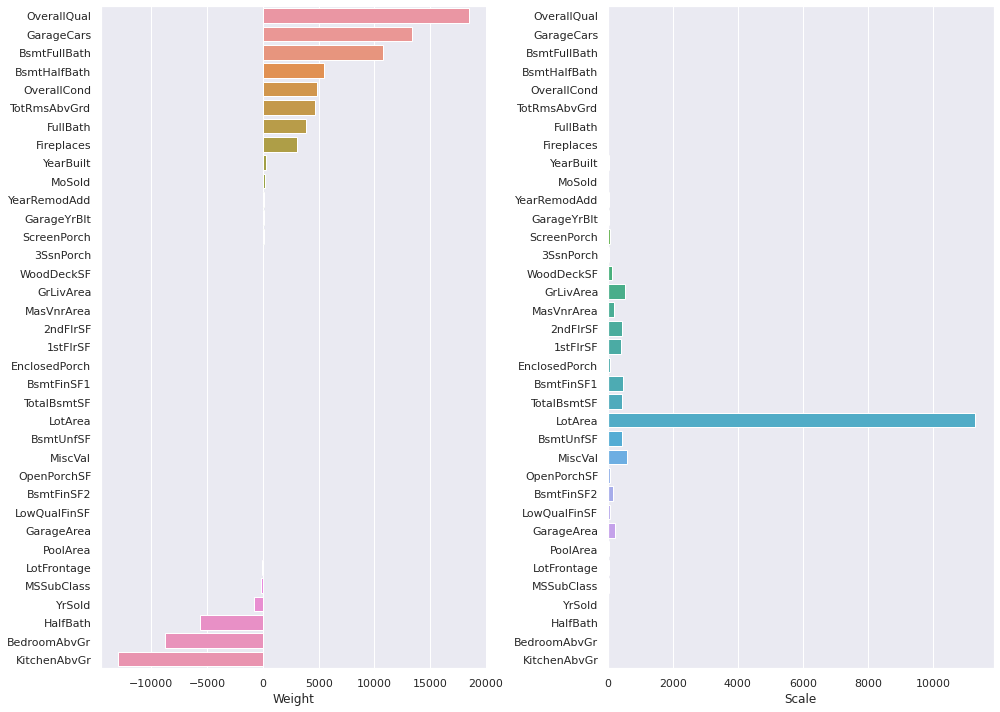

In [20]:
show_weights(numeric_features, model.coef_, X_train[numeric_features].std())

Будем масштабировать наши признаки перед обучением модели. Это, среди, прочего, сделает нашу регуляризацию более честной: теперь все признаки будут регуляризоваться в равной степени. 

Для этого воспользуемся трансформером [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Трансформеры в `sklearn` имеют методы `fit` и `transform` (а еще `fit_transform`). Метод `fit` принимает на вход обучающую выборку и считает по ней необходимые значения (например статистики, как `StandardScaler`: среднее и стандартное отклонение каждого из признаков). `transform` применяет преобразование к переданной выборке.

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

model = Ridge()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred))

Test MAE = 23115.1497
Train MAE = 21405.0062


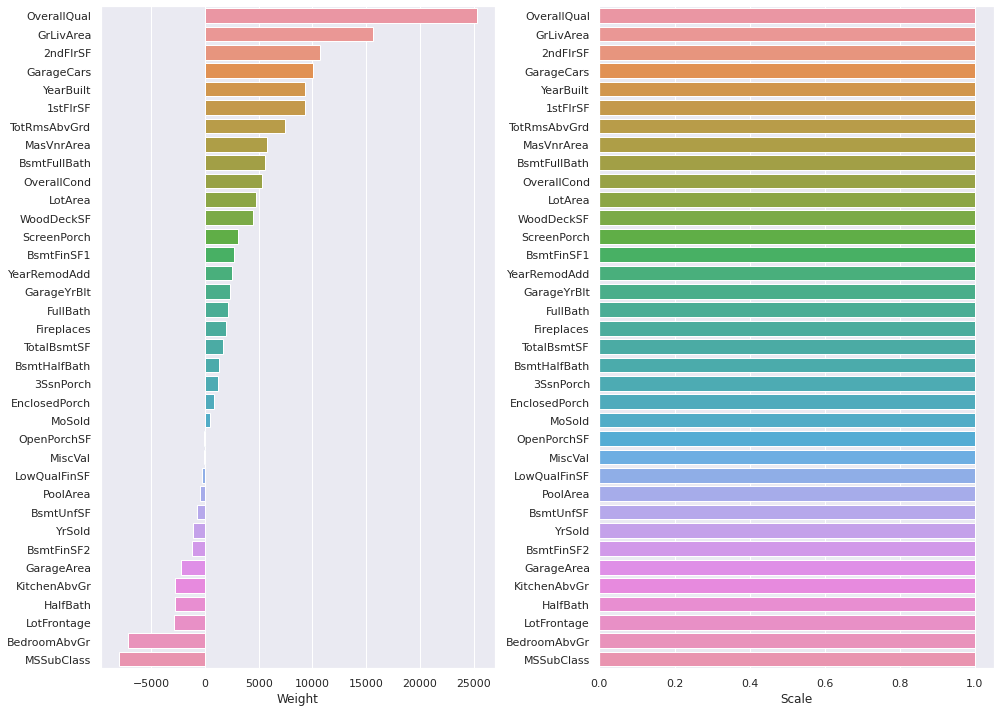

In [22]:
scales = pd.Series(data=X_train_scaled.std(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_, scales)

Наряду с параметрами (веса $w$, $w_0$), которые модель оптимизирует на этапе обучения, у модели есть и гиперпараметры. У нашей модели это `alpha` &mdash; коэффициент регуляризации. Подбирают его обычно по сетке, измеряя качество на валидационной (не тестовой) выборке или с помощью кросс-валидации. Посмотрим, как это можно сделать (заметьте, что мы перебираем `alpha` по логарифмической сетке, чтобы узнать оптимальный порядок величины).

Best alpha = 297.6351


Text(0, 0.5, 'CV score')

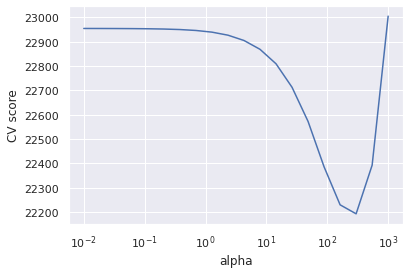

In [23]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_mean_absolute_error", cv=10)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

**Вопрос**: Почему мы не подбираем коэффициент регуляризации по обучающей выборке? По тестовой выборке?

Попробуем обучить модель с подобранным коэффициентом регуляризации. Заодно воспользуемся очень удобным классом [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): обучение модели часто представляется как последовательность некоторых действий с обучающей и тестовой выборками (например, сначала нужно отмасштабировать выборку (причем для обучающей выборки нужно применить метод `fit`, а для тестовой &mdash; `transform`), а затем обучить/применить модель (для обучающей `fit`, а для тестовой &mdash; `predict`). `Pipeline` позволяет хранить эту последовательность шагов и корректно обрабатывает разные типы выборок: и обучающую, и тестовую.

In [24]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))

Test MAE = 21724.8574


Видим, что качество модели улучшилось. Также бывает очень полезно посмотреть на примеры с большими остатками и попытаться понять, почему же модель на них так сильно ошибается: это может дать понимание, как модель можно улучшить.

# Часть 3. Работаем с категориальными признаками

Сейчас мы явно вытягиваем из данных не всю информацию, что у нас есть, просто потому, что мы не используем часть признаков. Эти признаки в датасете закодированы строками, каждый из них обозначает некоторую категорию. Такие признаки называются категориальными. Давайте выделим такие признаки и сразу заполним пропуски в них специальным значением (то, что у признака пропущено значение, само по себе может быть хорошим признаком).

In [25]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

In [26]:
X_train[categorical].sample(5)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
184,RL,Pave,NotGiven,IR1,Lvl,AllPub,Inside,Gtl,BrkSide,RRAn,Feedr,1Fam,1.5Fin,Gable,CompShg,AsbShng,Plywood,None,TA,TA,PConc,Fa,TA,No,Unf,Unf,GasA,Gd,Y,SBrkr,TA,Typ,NotGiven,Attchd,Unf,TA,TA,Y,NotGiven,MnPrv,NotGiven,WD,Normal
837,RM,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,Twnhs,2Story,Gable,CompShg,HdBoard,HdBoard,BrkFace,TA,TA,CBlock,TA,TA,No,BLQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,NotGiven,Detchd,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
1094,RL,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,TA,TA,No,BLQ,Rec,GasA,Ex,Y,SBrkr,TA,Typ,NotGiven,Attchd,Fin,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
1291,RM,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,Twnhs,2Story,Gable,CompShg,CemntBd,CmentBd,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,NotGiven,Detchd,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
436,RM,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,Stucco,Stucco,None,TA,TA,BrkTil,Fa,TA,No,Unf,Unf,GasA,TA,Y,FuseA,TA,Typ,NotGiven,Detchd,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal


Сейчас нам нужно как-то закодировать эти категориальные признаки числами, ведь линейная модель не может работать с такими абстракциями. Два стандартных трансформера из `sklearn` для работы с категориальными признаками &mdash; [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) (просто перенумеровывает значения признака натуральными числами) и [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

`OneHotEncoder` ставит в соответствие каждому признаку целый вектор, состоящий из нулей и одной единицы (которая стоит на месте, соответствующем принимаемому значению, таким образом кодируя его).

**Вопрос**: Проинтерпретируйте, что означают веса модели перед OneHot-кодированными признаками. Почему пользоваться `OrdinalEncoder` в случае линейной модели &mdash; скорее плохой вариант? Какие недостатки есть у OneHot-кодирования?

In [27]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))

Test MAE = 18595.8450


**Вопрос**: Как вы думаете, почему мы не производим скейлинг OneHot-кодированных признаков?

Посмотрим на размеры матрицы после OneHot-кодирования:

In [28]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Size before OneHot: (1022, 79)
Size after OneHot: (1022, 294)


Как видим, количество признаков увеличилось более, чем в 3 раза. Это может повысить риски переобучиться: соотношение количества объектов к количеству признаков сильно сократилось.

Попытаемся обучить линейную регрессию с $\ell_1$-регуляризатором. 

In [29]:
from sklearn.linear_model import Lasso

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("MAE = %.4f" % mean_absolute_error(y_test, y_pred))

MAE = 18548.6656


In [30]:
ridge_zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
lasso_zeros = np.sum(lasso_pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Ridge:", ridge_zeros)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Ridge: 0
Zero weights in Lasso: 29


Подберем для нашей модели оптимальный коэффициент регуляризации. Обратите внимание, как перебираются параметры у `Pipeline`.

In [ ]:
alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))

In [ ]:
lasso_zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Lasso:", lasso_zeros)

Иногда очень полезно посмотреть на распределение остатков. Нарисуем гистограмму распределения квадратичной ошибки на обучающих объектах:

In [ ]:
error = (y_train - model.predict(X_train)) ** 2
sns.distplot(error)

Как видно из гистограммы, есть примеры с очень большими остатками. Попробуем их выбросить из обучающей выборки. Например, выбросим примеры, остаток у которых больше 0.95-квантили.

In [ ]:
mask = (error < np.quantile(error, 0.95))

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train[mask], y_train[mask])
y_pred = model.predict(X_test)
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))

In [ ]:
X_train = X_train[mask]
y_train = y_train[mask]

In [ ]:
error = (y_train[mask] - model.predict(X_train[mask])) ** 2
sns.distplot(error)

Видим, что качество модели заметно улучшилось! Также бывает очень полезно посмотреть на примеры с большими остатками и попытаться понять, почему же модель на них так сильно ошибается: это может дать понимание, как модель можно улучшить.